# ZNEUS - Project 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch.nn as nn
import wandb
import random
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image


#google colab setup
prefix = ""
IS_COLAB = False
if IS_COLAB:
    !git clone https://github.com/ROmanGanushchak/ZNEUS-project2.git #clone files
    prefix = "ZNEUS-project2"


DATA = os.path.join(prefix, "data", "raw-img")
METAS = os.path.join(prefix, "data", "metas.csv")
RESIZED_DIR = os.path.join(prefix, "data", "resized_images")

os.makedirs(RESIZED_DIR, exist_ok=True)
correct_order = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
IS_FULL_EXECUTE = False
R_SEED = 42
IMG_SIZE = 224

#model parameters - initial configuration
EPOCH = 64
BATCH_SIZE = 96
LR = 0.001
WEIGHT_DECAY = 1e-4

#check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#wandb
WANDB_PROJECT_NAME = "zneus-project-2"
IS_WANDB = True
print(device)

cuda


In [2]:
translations = {"cane": "dog", "ragno": "spider", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

The translation was missing a mapping for 'rango' -> 'spider', the english -> italian was present

## Wandb init

In [23]:
def init_wandb(config_dict=None, run_name = "exp_0"):
    if IS_WANDB:
        default_config = {
            "model": "SimpleCNN",
            "batch_size": BATCH_SIZE,
            "learning_rate": LR,
            "epochs": EPOCH,
            "dataset": "Animals-10",
            "image_size": IMG_SIZE,
            "classes": correct_order
        }

        #use dict from tuning
        if config_dict is not None:
            default_config.update(config_dict)

        wandb.init(
            project=f"{WANDB_PROJECT_NAME}",
            name=run_name,
            config=default_config
        )

## 1. EDA
### 1.1 Load dataset

In [24]:
def extract_df_row_image(path, img):
    folder = os.path.basename(os.path.dirname(path))
    fname = os.path.basename(path)
    ext = os.path.splitext(fname)[1].lower()
    height, width, num_channels = img.shape
    return {
        "folder": folder,
        "file_path": path,
        "extension": ext,
        "width": width,
        "height": height,
        "num_channels": num_channels,
        "label": translations[folder],
        "ratio": round(float(width) / height, 3)
    }

def scan_images(root_folder: str) -> pd.DataFrame: #extract image info from files
    records = []

    for dirpath, _, filenames in os.walk(root_folder):
        for fname in filenames:
            file_path = os.path.join(dirpath, fname)
            img = cv2.imread(file_path)
            if img is None:
                print(f"Skipping invalid or missing image: {file_path}")
                continue #skip corrupted files

            records.append(extract_df_row_image(file_path, img))

    return pd.DataFrame(records)

In [3]:
if IS_FULL_EXECUTE:
    #go through all files and create a csv file with all the info, paths and parameters for further use
    df = scan_images(DATA)
    assert df["file_path"].is_unique
    df.to_csv(METAS, index=False)
else:
    #if it has already been done, we just read the csv
    df = pd.read_csv(METAS)

### 1.2 Duplicates

In [26]:
df.duplicated("file_path").sum()

np.int64(0)

There are no duplicate images.


### 1.3 Missing data

In [27]:
df.isna().sum(axis=0)

Unnamed: 0      0
folder          0
file_path       0
extension       0
width           0
height          0
num_channels    0
label           0
ratio           0
dtype: int64

No missing values after translation dictionary correction

### 1.4 Info about dataset

In [28]:
df.head()

,Unnamed: 0,folder,file_path,extension,width,height,num_channels,label,ratio
0,0,cane,data\raw-img\cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,.jpeg,300,225,3,dog,1.333
1,1,cane,data\raw-img\cane\OIP---A27bIBcUgX1qkbpZOPswHa...,.jpeg,300,214,3,dog,1.402
2,2,cane,data\raw-img\cane\OIP---cByAiEbIxIAleGo9AqOQAA...,.jpeg,153,300,3,dog,0.510
3,3,cane,data\raw-img\cane\OIP---ZIdwfUcJeVxnh47zppcQHa...,.jpeg,300,225,3,dog,1.333
4,4,cane,data\raw-img\cane\OIP---ZRsOF7zsMqhW30WeF8-AHa...,.jpeg,300,225,3,dog,1.333


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26181 entries, 0 to 26180
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    26181 non-null  int64  
 1   folder        26181 non-null  object 
 2   file_path     26181 non-null  object 
 3   extension     26181 non-null  object 
 4   width         26181 non-null  int64  
 5   height        26181 non-null  int64  
 6   num_channels  26181 non-null  int64  
 7   label         26181 non-null  object 
 8   ratio         26181 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.8+ MB


In our dataset we have 26179 entries and 7 columns, label is the target column.

#### Image ratio
Lets add column Image ratio to illustrate the ratio of width and height so we can filter images that are too "wide" or too "high".

In [30]:
df["ratio"].value_counts().nlargest(10).sort_values(ascending=False)

ratio
1.333    4591
1.500    3322
1.000    1279
1.775    1049
1.502     694
1.508     592
0.750     524
1.250     419
1.596     395
0.667     373
Name: count, dtype: int64

Images have very different proportions, the most common are 1.33 and 1.5.


### 1.5 Outliers in width, height, ratio

In [31]:
df.describe()

,Unnamed: 0,width,height,num_channels,ratio
count,26181.000000,26181.000000,26181.000000,26181.0,26181.000000
mean,13090.000000,320.025553,252.618196,3.0,1.311335
std,7557.948035,196.933647,148.403943,0.0,0.311217
min,0.000000,60.000000,57.000000,3.0,0.293000
25%,6545.000000,300.000000,200.000000,3.0,1.136000
50%,13090.000000,300.000000,225.000000,3.0,1.333000
75%,19635.000000,300.000000,300.000000,3.0,1.500000
max,26180.000000,6720.000000,6000.000000,3.0,4.225000


We can see, that some images are very large (width = 6720 or height = 6000) or some images have ratios > 4, these images are outliers.

### Find outliers

Number of width outliers: 42
Number of height outliers: 42
Number of ratio outliers: 8

Count:  8


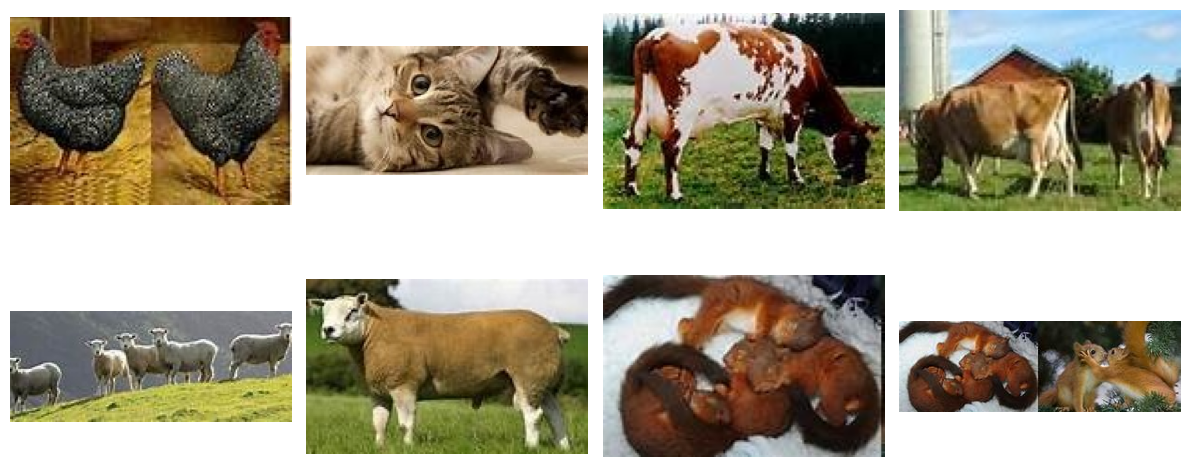

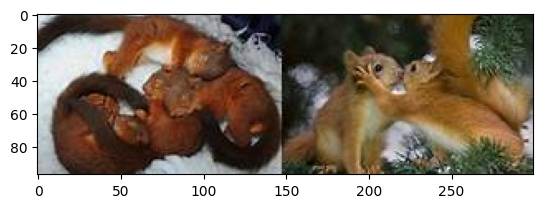

In [32]:
#lets say that we want only pictures in sizes of (50,1000) and ratio would be (0.3,3)
min_width, max_width = 50, 1000
min_height, max_height = 50, 1000
min_ratio, max_ratio = 0.3, 3

def check_outliers(df):
    #finding outliers
    outlier_width = df[(df['width'] < min_width) | (df['width'] > max_width)]
    outlier_height = df[(df['height'] < min_height) | (df['height'] > max_height)]
    outlier_ratio = df[(df['ratio'] < min_ratio) | (df['ratio'] > max_ratio)]

    print(f"Number of width outliers: {len(outlier_width)}")
    print(f"Number of height outliers: {len(outlier_height)}")
    print(f"Number of ratio outliers: {len(outlier_ratio)}\n")

check_outliers(df)

ratio_outliers = df[
    (df['ratio'] < min_ratio) | (df['ratio'] > max_ratio)
]
ratio_out_files = ratio_outliers['file_path'].tolist()
plt.figure(figsize=(12, 6))

print("Count: ", len(ratio_out_files))
for i, f in enumerate(ratio_out_files):
    img = Image.open(f)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

img = Image.open(ratio_out_files[-1])
plt.imshow(img)

Ratio outliers cropping

In [33]:
def crop(path: str, x1: float, x2: float, y1: float, y2: float):
    img = cv2.imread(path)
    h, w = img.shape[:2]

    l = int(x1 * w)
    r = int(x2 * w)
    t = int(y1 * h)
    b = int(y2 * h)

    return img[t:b, l:r]

def show_list(items):
    n = len(items)
    cols = 4
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, (name, img) in enumerate(items):
        # convert BGR → RGB for matplotlib
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(rgb)
        # plt.title(name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def save_crops(cropped):
    print("Saving")
    saved = []
    last_path = None

    for path, img in cropped:
        dirpath = os.path.dirname(path)
        base = os.path.basename(path)
        name, ext = os.path.splitext(base)

        if path == last_path:
            suffix = f"_{random.randint(10000, 99999)}"
            out_path = os.path.join(dirpath, name + suffix + ext)
            saved.append(extract_df_row_image(out_path, img))
        else:
            out_path = path

        last_path = path
        cv2.imwrite(out_path, img)

    return saved

if IS_FULL_EXECUTE:
    fs = ratio_out_files
    cropped = [
        (fs[0], crop(fs[0], 0, 0.475, 0, 1)),
        (fs[0], crop(fs[0], 0.475, 0.95, 0, 1)),
        (fs[1], crop(fs[1], 0.3, 0.97, 0, 1)),
        (fs[2], crop(fs[2], 0, 0.475, 0, 1)),
        (fs[3], crop(fs[3], 0.25, 0.65, 0, 1)),
        (fs[4], crop(fs[4], 0.2, 0.8, 0, 1)),
        (fs[5], crop(fs[5], 0.25, 0.77, 0, 1)),
        (fs[6], crop(fs[7], 0, 0.5, 0, 1)),
        (fs[6], crop(fs[7], 0.5, 1, 0, 1)),
    ]
    show_list(cropped)
    added = save_crops(cropped)
    print("Added: ", added)
    df = pd.concat([df, pd.DataFrame(added)], ignore_index=True)
    df.to_csv(METAS, index=False)

### 1.6 Visualize data

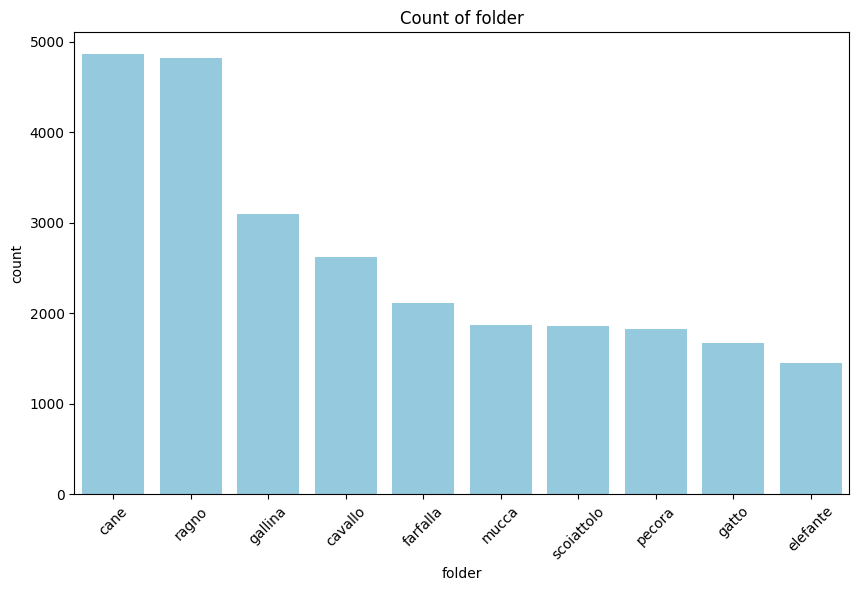

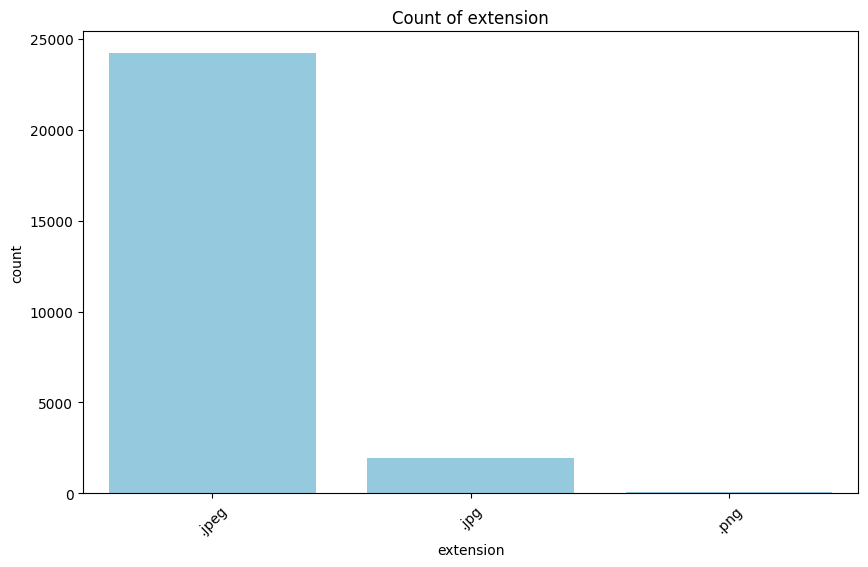

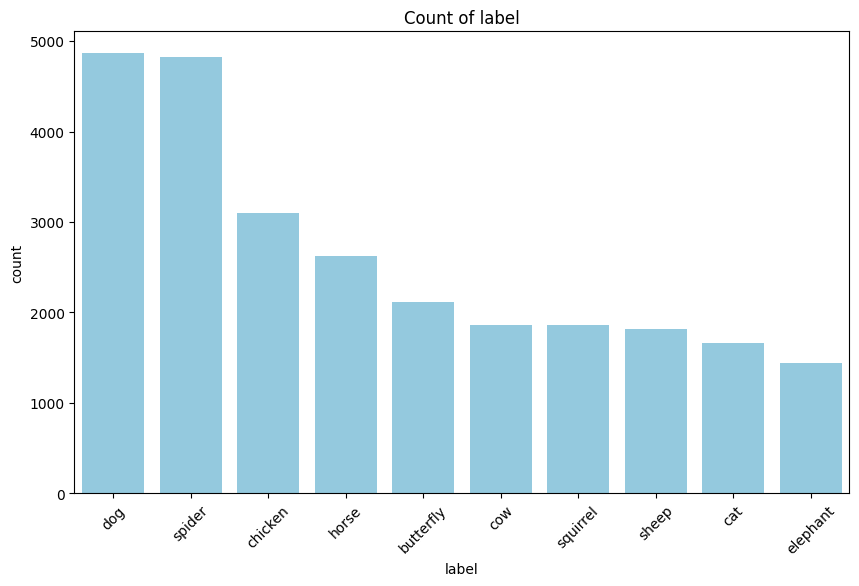

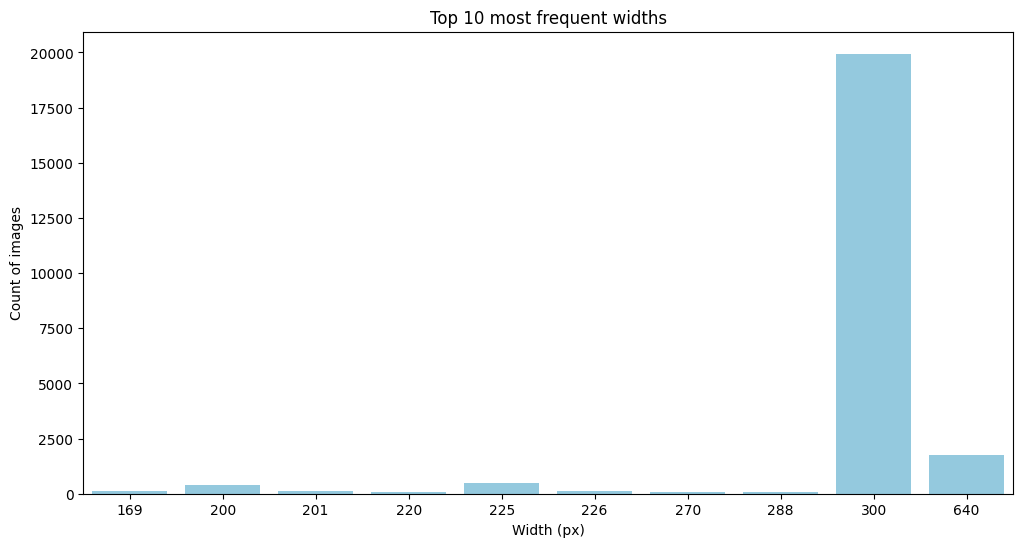

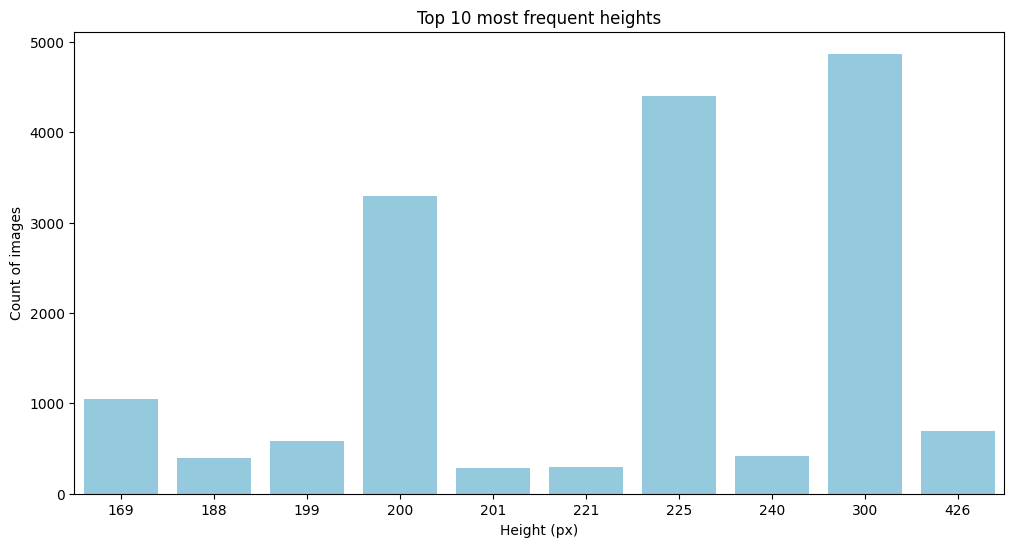

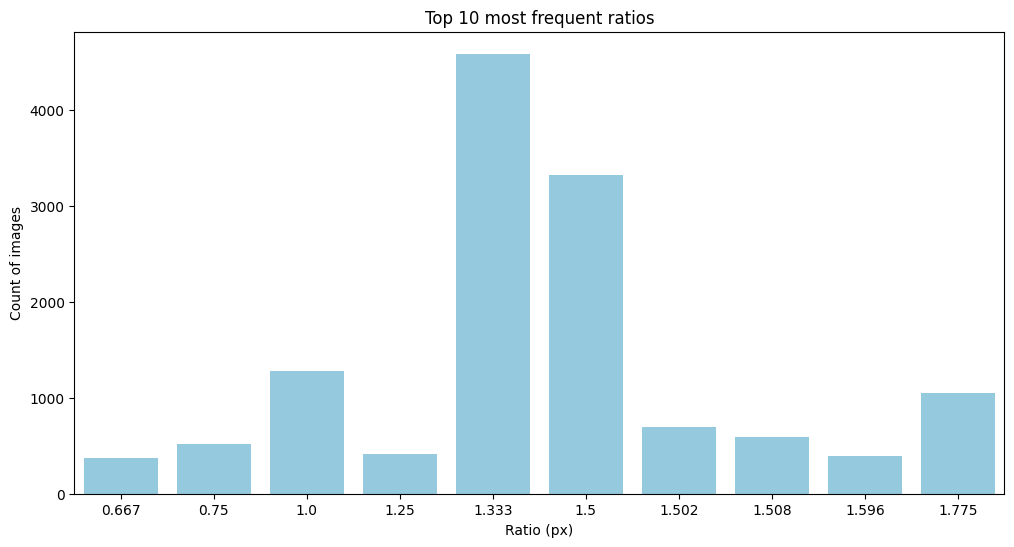

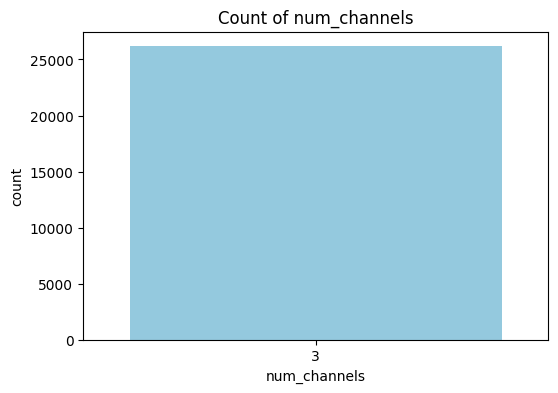

In [34]:
cat_cols = ["folder", "extension", "label"]
num_cols = ["width", "height", "num_channels"]
top_ten_cols = ["width", "height", "ratio"]

#draw categorical columns
for col in cat_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, color="skyblue")
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()

#draw top-ten most common valeus columns
for col in top_ten_cols:
    top_counts = df[col].value_counts().nlargest(10).sort_index()  #10 most common values
    plt.figure(figsize=(12,6))
    sns.barplot(x=top_counts.index, y=top_counts.values, color='skyblue')
    plt.title(f"Top 10 most frequent {col}s")
    plt.xlabel(f"{col.capitalize()} (px)")
    plt.ylabel("Count of images")
    plt.show()

#draw num_of_channels
plt.figure(figsize=(6,4))
sns.countplot(x=df["num_channels"], data=df, color="skyblue")
plt.title("Count of num_channels")
plt.show()

- We can see, that almost half of all the pictures are dogs and spiders.
- All the images use 3 channels.
- .jpeg is the most common, yet they all are using 3-channels, and cv2 can work with all of them so there is no need for convertion
- Almost all of the widths are values: 300 and 640
- Heights are more varied, most common are: 300, 225, 200 and 169

### 1.7 Evaluation metrics

For evaluation we will use:
- Precision
- Accuracy
- Recall
- F1
- Confusion Matrix
- Per class accuracy

## 2. Preprocessing
### 2.1 Resize images

In [4]:
TARGET_SIZE = (IMG_SIZE, IMG_SIZE) #we will resize all images to IMG_SIZExIMG_SIZE

def is_resized_done(resized_dir, labels): #if we already resized the images
    if not os.path.exists(resized_dir):
        return False
    #if the subfolders are there too
    for label in labels:
        label_path = os.path.join(resized_dir, label)
        if not os.path.exists(label_path) or len(os.listdir(label_path)) == 0:
            return False
    return True


if False and not IS_FULL_EXECUTE and is_resized_done(RESIZED_DIR, df['label'].unique()):
    print("Resized images already exist. Skipping resize.")
else:
    print("Resizing images...")
    #create subfolders from labels
    for label in df['label'].unique():
        os.makedirs(os.path.join(RESIZED_DIR, label), exist_ok=True)

    #resize and save files
    for idx, row in df.iterrows():
        img_path = row['file_path']
        label = row['label']
        save_path = os.path.join(RESIZED_DIR, label, os.path.basename(img_path))
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize(TARGET_SIZE)
        img_resized.save(save_path)

    print("All images resized and saved.")


Resizing images...
All images resized and saved.


### 2.2 Split dataset

In [36]:
#70% train, 15% val, 15% test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=R_SEED)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=R_SEED)

Stratify will keep the class ratios from the original dataset so in the split, all classes are represented in the same ratio as originally.

### 2.3 Dataset class

In [37]:
class ResizedAnimalDataset(Dataset):
    def __init__(self, df, resized_dir, labels_map=None):
        self.df = df.reset_index(drop=True)
        self.resized_dir = resized_dir
        self.labels_map = labels_map

        self.images = []
        self.labels = []

        print("Preloading and preprocessing images ...")
        for i in tqdm(range(len(self.df)), desc="Preprocessing", ncols=100):
            row = self.df.iloc[i]

            clean_path = row['file_path'].replace("\\", "/") #remove Windows \\ so Colab can use it
            file_name = os.path.basename(clean_path) #extract file name

            img_path = os.path.join(resized_dir, row['label'], file_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            self.images.append(img)
            self.labels.append(self.labels_map[row['label']])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # print(img.shape)
        # img = img.transpose(2, 0, 1)
        # print(img.shape)
        # img = to_tensor(img)

        return img, label

### 2.3 Augmentations and Normalization
#### 2.3.1 Pipelines

In [38]:
from torchvision.transforms import v2 as T
class GaussianNoise(T.Transform):
    def __init__(self, alpha=0.05):
        super().__init__()
        self.alpha = alpha
    
    def _get_params(self, flat_inputs):
        return {}

    def transform(self, img, params):
        return img + torch.randn_like(img) * self.alpha

In [39]:
train_transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
    T.ToTensor(),
    T.Lambda(lambda img: img + torch.randn_like(img) * 0.02), # Gausian noise
    T.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010))
])

static_transform = T.Compose([
    T.ToImage(),                                      # same as train
    T.ToDtype(torch.float32, scale=True),             # same as train
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )
])

d:\University\zneus\ZNEUS-project2_2\ZNEUS-project2\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


#### 2.3.2 Apply preprocessing

In [40]:
all_labels = df_train['label'].unique() #order of classes
labels_map = {label: idx for idx, label in enumerate(all_labels)}

train_dataset = ResizedAnimalDataset(df_train, RESIZED_DIR, labels_map=labels_map)
val_dataset = ResizedAnimalDataset(df_val, RESIZED_DIR, labels_map=labels_map)
test_dataset = ResizedAnimalDataset(df_test, RESIZED_DIR, labels_map=labels_map)

#create data loaders for all datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

Preloading and preprocessing images ...


Preprocessing: 100%|██████████████████████████████████████████| 18326/18326 [08:22<00:00, 36.47it/s]


Preloading and preprocessing images ...


Preprocessing: 100%|████████████████████████████████████████████| 3927/3927 [01:21<00:00, 48.07it/s]


Preloading and preprocessing images ...


Preprocessing: 100%|████████████████████████████████████████████| 3928/3928 [00:58<00:00, 67.64it/s]


In [41]:
train_counts = [len(df_train[df_train['label'] == cls]) for cls in all_labels]
weights = len(df_train) / (10 * torch.tensor(train_counts, dtype=torch.float))
weights

tensor([1.2399, 1.4054, 0.5430, 0.9981, 1.4032, 1.4385, 0.5384, 0.8449, 1.8109,
        1.5690])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04512757..1.0516871].


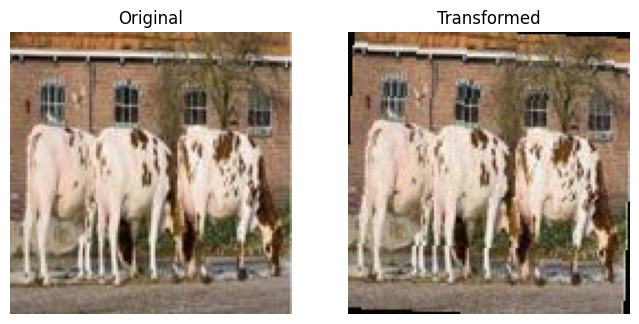

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06135404..1.0118387].


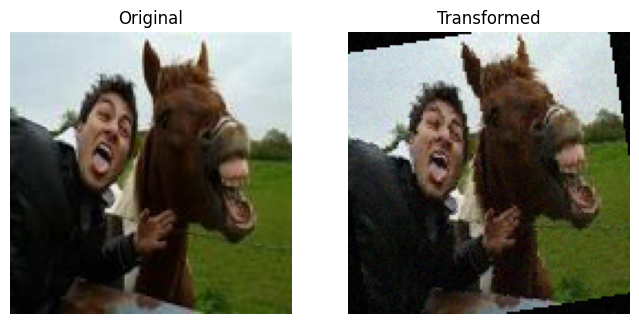

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0727489..1.0323085].


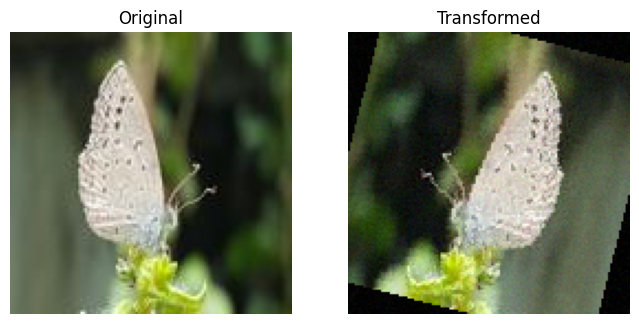

In [42]:
def unnormalize(img, mean, std):
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]
    return img * std + mean

def show(img, ax):
    # img is (C, H, W) torch tensor in [0,1]
    img = img.detach().cpu()
    img = img.permute(1, 2, 0)       # (H, W, C)
    ax.imshow(img)
    ax.axis("off")

start = random.randint(0, len(train_dataset) - 3)
for i in range(start, start+3, 1):
  # grab one sample from your dataset
  img_np, label = train_dataset[i]

  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].set_title("Original")
  ax[1].set_title("Transformed")

  # convert original numpy image to displayable form
  ax[0].imshow(img_np)
  ax[0].axis("off")

  img_t = train_transform(img_np)
  show(unnormalize(img_t,
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010)
  ), ax[1])

  plt.show()

## 3. CNN Model
### 3.1 Init model

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, pool_csl):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU(),

            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(0.1)
        )

        self.shortcut = None
        if in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1),
                nn.BatchNorm2d(out_c)
            )
        self.act = nn.GELU()
        self.pool = pool_csl(2)

    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x) if self.shortcut else x
        out = self.act(out)
        return self.pool(out)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            ResidualBlock(3, 32, nn.MaxPool2d),
            ResidualBlock(32, 64, nn.MaxPool2d),
            ResidualBlock(64, 128, nn.MaxPool2d),
            ResidualBlock(128, 256, nn.AvgPool2d)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=10)
model.to(device); #send model to available proccessing unit (GPU or CPU)


### 3.2 CUDA performance optimization

In [44]:
torch.backends.cudnn.benchmark = True #selects the best CNN algorithms, uses GPU as much as possible, boost 50%, 4 it/s -> 6 it/s

### 3.2 Loss and optimizer

In [45]:
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #classification metric
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

### 3.3 Evaluate

In [46]:
def evaluate(model, loader, is_test, epoch=None):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    batch_accuracies = []
    batch_class_accuracies = []
    class_names_ordered = [k for k, v in sorted(labels_map.items(), key=lambda x: x[1])]

    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(loader, start=1):
            imgs = imgs.permute(0, 3, 1, 2)
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = static_transform(imgs)
            outputs = model(imgs) #prediction

            #calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            #add labels and preds to arrays for confusion matrix
            preds = outputs.argmax(dim=1) #our predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if is_test:
                batch_acc = 100.0 * (preds == labels).sum().item() / labels.size(0)
                batch_accuracies.append(batch_acc)

                #per class accuracies per batch
                batch_correct = {name: 0.0 for name in class_names_ordered}
                batch_total = {name: 0 for name in class_names_ordered}

                for i in range(len(labels)):
                    true_label = class_names_ordered[labels[i].item()]
                    pred_label = class_names_ordered[preds[i].item()]
                    batch_total[true_label] += 1
                    if true_label == pred_label:
                        batch_correct[true_label] += 1

                batch_acc_per_class = {
                    name: (batch_correct[name] / max(batch_total[name], 1)) * 100.0
                    for name in class_names_ordered
                }

                batch_class_accuracies.append(batch_acc_per_class)
                log_step = batch_idx  # každý batch = jeden krok na x-ovej osi
                log_data = {"test/batch_step": log_step}

                for name in class_names_ordered:
                    log_data[f"test/batch_acc_{name}"] = batch_acc_per_class[name]

                wandb.log(log_data, step=log_step)


    #loss and metrics
    avg_loss = total_loss / len(loader)
    total_acc = 100.0 * accuracy_score(all_labels, all_preds)
    precision = 100.0 * precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = 100.0 * recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = 100.0 * f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    #per class accuracy
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names_ordered)))
    per_class_acc = 100.0 * cm.diagonal() / (cm.sum(axis=1) + 1e-8)

    #print to console
    if is_test:
        set_name = "TEST" if is_test else "VAL"
        print(f"\n=== {set_name} EVALUATION {'(FINAL)' if is_test else f'(Epoch {epoch})'} ===")
        print(f"{set_name} Loss: {avg_loss:.4f} | Accuracy: {total_acc:.2f}% | Precision: {precision:.2f}% | Recall: {recall:.2f}% | F1: {f1:.2f}%\n")

        print(f"{'Class':15} {'Count':>6} {'Acc':>8} {'Correct'}")
        print("-" * 45)
        for i, name in enumerate(class_names_ordered):
            count = int(cm.sum(axis=1)[i])
            correct = int(cm[i, i])
            print(f"{name:15} {count:6} {per_class_acc[i]:7.2f}% {correct:6}")
        print("-" * 45)
        print(f"{'TOTAL':15} {len(all_labels):6} {total_acc:7.2f}%\n")

    #log to wandb
    log_dict = {
        f"{'test' if is_test else 'val'}/loss": avg_loss,
        f"{'test' if is_test else 'val'}/accuracy": total_acc,
        f"{'test' if is_test else 'val'}/precision": precision,
        f"{'test' if is_test else 'val'}/recall": recall,
        f"{'test' if is_test else 'val'}/f1": f1,
        "epoch": epoch if epoch is not None else 0,
    }


    #confusion matrix only for test set
    if is_test:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names_ordered, yticklabels=class_names_ordered,
                    cbar_kws={'label': 'Počet'})
        plt.title(f"Confusion Matrix – TEST SET\nAccuracy: {total_acc:.2f}%", fontsize=14)
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

        log_dict["test/confusion_matrix"] = wandb.Image(plt)
        plt.close()


        #per class acc table
        table = wandb.Table(columns=["Class", "Count", "Accuracy %", "Correct"])
        for i, name in enumerate(class_names_ordered):
            table.add_data(name, int(cm.sum(axis=1)[i]), round(per_class_acc[i], 2), int(cm[i,i]))
        table.add_data("TOTAL", len(all_labels), round(total_acc, 2), int(cm.trace()))
        log_dict["test/per_class_table"] = table

    return total_acc, avg_loss, per_class_acc, cm, log_dict, batch_accuracies

### 3.3 Train

In [47]:
def train(train_loader, val_loader, test_loader, model, print_res=False):
    scaler = torch.cuda.amp.GradScaler()
    best_val_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    loader_total, model_total = 0, 0

    for epoch in range(EPOCH):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH}", leave=False) #progress prints

        prev_time = time.perf_counter()
        for imgs, labels in progress_bar:
            imgs = imgs.permute(0, 3, 1, 2)
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = train_transform(imgs)
            loader_time = time.perf_counter() - prev_time
            loader_total += loader_time

            model_start = time.perf_counter()

            optimizer.zero_grad(set_to_none=True)

            #make prediction and calculate loss
            with torch.amp.autocast('cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            #backward propagation
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
            
            prev_time = time.perf_counter()
            model_total += prev_time - model_start

        avg_train_loss = total_train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss) #add loss to history

        #validation
        val_acc, val_loss, per_class_acc, _, log_dict, _ = evaluate(
            model, val_loader, is_test=False, epoch=epoch+1
        )

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        #save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved! Val acc: {val_acc:.2f}%")

        #log into wandb
        wandb.log({
            "epoch": epoch+1,
            "train/loss": avg_train_loss,
            "val/loss": val_loss,
            "val/accuracy": val_acc,
            "best_val_acc": best_val_acc
        },step=epoch+1)

        #log eval data
        wandb.log(log_dict,step=epoch+1)

        if print_res:
            print(f"Epoch {epoch+1}: Train loss: {avg_train_loss:.4f}, Val loss: {0:.4f}, Val acc={0*100:.2f}%")
            print(f"Dataloader time (sum): {loader_total:.4f} s")
            print(f"Model time (sum):      {model_total:.4f} s")

    #evaluate on TEST dataset
    model.load_state_dict(torch.load("best_model.pth"))
    test_acc, test_loss, per_class, cm, log_dict, batch_accs = evaluate(
        model, test_loader, is_test=True, epoch=EPOCH
    )
    #log test data
    #wandb.log(log_dict)

    #print(batch_accs)

    for i, acc in enumerate(batch_accs, start=1):
        #print("logujeeeem",acc)
        wandb.log({"test/per_batch": acc}) #todo fix x-axis

    wandb.log({
        **log_dict,
    })


    print(f"\nTEST ACCURACY: {test_acc:.2f}%")
    wandb.summary["test_accuracy"] = test_acc
    wandb.summary["loader_total_time"] = loader_total / EPOCH
    wandb.summary["training_total_time"] = model_total / EPOCH
    print(f"loader_total_time: {loader_total}, training_total_time: {model_total}")

    return model, history

### 3.4 Train the model

In [48]:
init_wandb(run_name="dropout_0.3+lr_1e-3+decay_1e-4")

trained_model, history = train(train_loader, val_loader, test_loader, model, print_res=True)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xhanushchak (xhanushchak-slovensk-technick-univerzita-v-bratislave). Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
C:\Users\RomOxy\AppData\Local\Temp\ipykernel_14992\2365311035.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


New best model saved! Val acc: 43.16%
Epoch 1: Train loss: 2.0865, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 3.5419 s
Model time (sum):      45.0648 s


New best model saved! Val acc: 43.82%
Epoch 2: Train loss: 1.5107, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 5.6210 s
Model time (sum):      78.5089 s


New best model saved! Val acc: 54.24%
Epoch 3: Train loss: 1.3142, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 7.7648 s
Model time (sum):      112.1178 s


New best model saved! Val acc: 59.08%
Epoch 4: Train loss: 1.1797, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 9.7826 s
Model time (sum):      145.7728 s


New best model saved! Val acc: 59.59%
Epoch 5: Train loss: 1.0954, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 11.8211 s
Model time (sum):      179.5504 s


New best model saved! Val acc: 62.92%
Epoch 6: Train loss: 0.9943, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 13.8657 s
Model time (sum):      213.3386 s


Epoch 7: Train loss: 0.9130, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 15.8613 s
Model time (sum):      247.1446 s


New best model saved! Val acc: 68.83%
Epoch 8: Train loss: 0.8393, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 17.8668 s
Model time (sum):      280.9589 s


Epoch 9: Train loss: 0.7725, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 19.8622 s
Model time (sum):      314.7865 s


New best model saved! Val acc: 73.54%
Epoch 10: Train loss: 0.7202, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 21.8505 s
Model time (sum):      348.6053 s


Epoch 11: Train loss: 0.6683, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 23.8404 s
Model time (sum):      382.4331 s


Epoch 12: Train loss: 0.6178, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 25.8658 s
Model time (sum):      416.2591 s


New best model saved! Val acc: 74.31%
Epoch 13: Train loss: 0.5652, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 27.8833 s
Model time (sum):      450.0937 s


New best model saved! Val acc: 75.78%
Epoch 14: Train loss: 0.5477, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 29.8834 s
Model time (sum):      483.9082 s


Epoch 15: Train loss: 0.4981, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 31.8694 s
Model time (sum):      517.7308 s


New best model saved! Val acc: 77.21%
Epoch 16: Train loss: 0.4763, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 33.8620 s
Model time (sum):      551.5551 s


Epoch 17: Train loss: 0.4416, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 35.8744 s
Model time (sum):      585.4018 s


Epoch 18: Train loss: 0.4150, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 37.8921 s
Model time (sum):      619.2492 s


Epoch 19: Train loss: 0.3944, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 39.9006 s
Model time (sum):      653.0787 s


Epoch 20: Train loss: 0.3729, Val loss: 0.0000, Val acc=0.00%
Dataloader time (sum): 41.9291 s
Model time (sum):      686.9397 s


C:\Users\RomOxy\AppData\Local\Temp\ipykernel_14992\2365311035.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
wandb:


=== TEST EVALUATION (FINAL) ===
TEST Loss: 0.7609 | Accuracy: 78.62% | Precision: 79.66% | Recall: 78.62% | F1: 78.78%

Class            Count      Acc Correct
---------------------------------------------
butterfly          317   92.43%    293
squirrel           279   78.85%    220
spider             724   84.53%    612
horse              393   77.61%    305
cow                280   69.64%    195
sheep              273   69.60%    190
dog                730   72.60%    530
chicken            465   78.06%    363
elephant           217   82.95%    180
cat                250   80.00%    200
---------------------------------------------
TOTAL             3928   78.62%


TEST ACCURACY: 78.62%
loader_total_time: 41.92911580193322, training_total_time: 686.9397396980203


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
